In [2]:
# ------------------------------mount drive-------------------------------------
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/Colab\ Notebooks/nonlinear-sys-id/quadrotor\ neurips/

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/nonlinear-sys-id/quadrotor neurips


# Getting Trajectory Data of Quadrotor

In [3]:
import numpy as np
from scipy.stats import truncnorm
import random
import matplotlib.pyplot as plt
import math


g = 9.81  # (m/s^2)  gravity constant
dt = 0.01  # time_step for discrete-time system


def system_parameters():
    # -------------------------- Quadcoptor --------------------------
    I_xx = 4.856e-3  # (kg/m^2) moment of inertia
    I_yy = 4.856e-3  # (kg/m^2) moment of inertia
    I_zz = 8.801e-3  # (kg/m^2) moment of inertia
    m = 0.468  # (kg)    weight
    Ax = 0.25  # (kg/s)  drag force coefficients
    Ay = 0.25  # (kg/s)  drag force coefficients
    Az = 0.25  # (kg/s)  drag force coefficients
    # --------------------------- Rotor -------------------------------
    l = 0.225  # (m) distance between the rotor and the center of mass
    k = 2.980e-6  # lift constant of the rotor
    b = 1.140e-7  # drag constant of the rotor
    I_r = 3.357e-5  # (kg/m^2) moment of inertia
    return I_xx, I_yy, I_zz, Ax, Ay, Az, m, l, k, b, I_r


def euler_to_quaternion(roll, pitch, yaw):

    cr = np.cos(roll * 0.5)
    sr = np.sin(roll * 0.5)
    cp = np.cos(pitch * 0.5)
    sp = np.sin(pitch * 0.5)
    cy = np.cos(yaw * 0.5)
    sy = np.sin(yaw * 0.5)

    q0 = cr * cp * cy + sr * sp * sy
    q1 = sr * cp * cy - cr * sp * sy
    q2 = cr * sp * cy + sr * cp * sy
    q3 = cr * cp * sy - sr * sp * cy

    return q0, q1, q2, q3


def generate_u(input_, time_hor, s_, mean, std, u_max, lb, ub):  # noise in control input
    if input_ == "trunc_guass":
        np.random.seed(s_)
        rv = truncnorm(-u_max, u_max, loc=mean, scale=std)
        r1 = rv.rvs(size=time_hor)
        rv = truncnorm(-u_max, u_max, loc=mean, scale=std)
        r2 = rv.rvs(size=time_hor)
        rv = truncnorm(-u_max, u_max, loc=mean, scale=std)
        r3 = rv.rvs(size=time_hor)
        rv = truncnorm(-u_max, u_max, loc=mean, scale=std)
        r4 = rv.rvs(size=time_hor)
        return r1, r2, r3, r4
    elif input_ == "uniform":
        np.random.seed(s_)
        r1 = np.random.uniform(low=lb, high=ub, size=time_hor)
        r2 = np.random.uniform(low=lb, high=ub, size=time_hor)
        r3 = np.random.uniform(low=lb, high=ub, size=time_hor)
        r4 = np.random.uniform(low=lb, high=ub, size=time_hor)
        return r1, r2, r3, r4


def generate_w(distr, time_hor, s_, mean, std, w_max, lb, ub):  # disturbance
    if distr == "trunc_guass":
        np.random.seed(s_)
        rv = truncnorm(-w_max, w_max, loc=mean, scale=std)
        r1 = rv.rvs(size=time_hor)
        rv = truncnorm(-w_max, w_max, loc=mean, scale=std)
        r2 = rv.rvs(size=time_hor)
        rv = truncnorm(-w_max, w_max, loc=mean, scale=std)
        r3 = rv.rvs(size=time_hor)
        rv = truncnorm(-w_max, w_max, loc=mean, scale=std)
        r4 = rv.rvs(size=time_hor)
        rv = truncnorm(-w_max, w_max, loc=mean, scale=std)
        r5 = rv.rvs(size=time_hor)
        rv = truncnorm(-w_max, w_max, loc=mean, scale=std)
        r6 = rv.rvs(size=time_hor)
        return r1, r2, r3, r4, r5, r6
    elif distr == "uniform":
        np.random.seed(s_)
        r1 = np.random.uniform(low=lb, high=ub, size=time_hor)
        r2 = np.random.uniform(low=lb, high=ub, size=time_hor)
        r3 = np.random.uniform(low=lb, high=ub, size=time_hor)
        r4 = np.random.uniform(low=lb, high=ub, size=time_hor)
        r5 = np.random.uniform(low=lb, high=ub, size=time_hor)
        r6 = np.random.uniform(low=lb, high=ub, size=time_hor)
        return r1, r2, r3, r4, r5, r6


class QuadrotorDynamics:
    def __init__(self, distr, input):
        self.distr = distr
        self.input = input
        self.I_xx, self.I_yy, self.I_zz, self.Ax, self.Ay, self.Az, self.m, self.l, self.k, self.b, self.I_r = system_parameters()
        self.px_list = []
        self.py_list = []
        self.pz_list = []
        self.vx_list = []
        self.vy_list = []
        self.vz_list = []
        self.q0_list = []
        self.q1_list = []
        self.q2_list = []
        self.q3_list = []
        self.wx_list = []
        self.wy_list = []
        self.wz_list = []
        self.phi_s_u_list = []
        self.b_s_list = []
        self.u1_lis = []
        self.u2_lis = []
        self.u3_lis = []
        self.u4_lis = []

    def plot_trajectory(self):
        t_list = np.array(range(len(self.px_list))) * dt
        fig = plt.figure()
        plt.plot(t_list, self.px_list, label='$p_{x}$')
        plt.plot(t_list, self.py_list, label='$p_{y}$')
        plt.plot(t_list, self.pz_list, label='$p_{z}$')
        plt.title("Quadrotor's Position")
        plt.xlabel('time (s)')
        plt.ylabel("Quadrotor's Position")
        plt.legend()

        fig = plt.figure()
        plt.plot(t_list, self.vx_list, label='$v_{x}$')
        plt.plot(t_list, self.vy_list, label='$v_{y}$')
        plt.plot(t_list, self.vz_list, label='$v_{z}$')
        plt.title("Quadrotor's Translation Velocity")
        plt.xlabel('time (s)')
        plt.ylabel("Quadrotor's Translation Velocity")
        plt.legend()

        fig = plt.figure()
        plt.plot(t_list, self.q0_list, label='$q_{0}$')
        plt.plot(t_list, self.q1_list, label='$q_{1}$')
        plt.plot(t_list, self.q2_list, label='$q_{2}$')
        plt.plot(t_list, self.q3_list, label='$q_{3}$')
        plt.title("Quaternions")
        plt.xlabel('time (s)')
        plt.ylabel("Quaternion")
        plt.legend()

        fig = plt.figure()
        plt.plot(t_list, self.wx_list, label='$\omega_{x}$')
        plt.plot(t_list, self.wy_list, label='$\omega_{y}$')
        plt.plot(t_list, self.wz_list, label='$\omega_{z}$')
        plt.title("Quadrotor's Angular Velocity")
        plt.xlabel('time (s)')
        plt.ylabel("Quadrotor's Angular Velocity")
        plt.legend()

        fig = plt.figure()
        plt.plot(t_list[1:], self.u1_lis, label='$u_{1}$')
        plt.plot(t_list[1:], self.u2_lis, label='$u_{2}$')
        plt.plot(t_list[1:], self.u3_lis, label='$u_{3}$')
        plt.plot(t_list[1:], self.u4_lis, label='$u_{4}$')
        plt.title("control")
        plt.xlabel('time (s)')
        plt.ylabel("control")
        plt.legend()

        plt.show()

    def update_feature_list(self, phi_s_u, s_, s, ex):
        self.phi_s_u_list.append(phi_s_u)
        self.b_s_list.append(s - s_ - ex)


    def get_trajectory_3(self, x0, time_hor, s_u, s_w, param_u, mult_u, param_w):

        g_ = np.array([0, 0, g])  # gravity vector in inertial frame
        J = np.diag(np.array([self.I_xx, self.I_yy, self.I_zz]))  # inertia matrix
        drag = np.diag(np.array([self.Ax, self.Ay, self.Az]))  # drag force coefficients

        # ----------------------------------------- initial states -----------------------------------------------------
        x = np.array(x0)
        p = x[:3]  # position in inertial frame
        v = x[3:6]  # velocity in inertial frame
        q = x[6:10]  # quaternions
        omega = x[10:]  # angular velocity in body frame

        #  ------------------------------------- Storing the states - ---------------------------------------------
        self.px_list = [p[0]]
        self.py_list = [p[1]]
        self.pz_list = [p[2]]

        self.vx_list = [v[0]]
        self.vy_list = [v[1]]
        self.vz_list = [v[2]]

        self.q0_list = [q[0]]
        self.q1_list = [q[1]]
        self.q2_list = [q[2]]
        self.q3_list = [q[3]]

        self.wx_list = [omega[0]]
        self.wy_list = [omega[1]]
        self.wz_list = [omega[2]]

        if self.input == "trunc_guass":
          u_max_ = param_u[2]
        else:
          u_max_ = 1.0

        if self.distr == "trunc_guass":
          w_max_ = param_w[2]
        else:
          w_max_ = 1.0

        # -----------------  random noise and disturbance generation ---------------------------------------------------
        U1_list, U2_list, U3_list, U4_list = generate_u(self.input, time_hor, s_u, mean=param_u[0], std=param_u[1], u_max=u_max_, lb=param_u[0], ub=param_u[1])
        W1_list, W2_list, W3_list, W4_list, W5_list, W6_list = generate_w(self.distr, time_hor, s_w, mean=param_w[0], std=param_w[1], w_max=w_max_, lb=param_w[0], ub=param_w[1])

        # ---------------------------------- controller gains  ------------------------------------------------------
        kp_z = 0.75
        kd_z = 1.25
        kp_phi = 0.03
        kp_theta = 0.03
        kp_psi = 0.03
        kd_phi = 0.00875
        kd_theta = 0.00875
        kd_psi = 0.00875

        # ---------------------------------   desired states   ---------------------------------------------------------
        pz_d = 5.
        vz_d = 0.
        q0_d, q1_d, q2_d, q3_d = euler_to_quaternion(0, 0, 0)

        for t in range(time_hor):

            s_ = np.array([v[0], v[1], v[2], omega[0], omega[1], omega[2]])

            q0 = q[0]
            q1 = q[1]
            q2 = q[2]
            q3 = q[3]

            omega1 = omega[0]
            omega2 = omega[1]
            omega3 = omega[2]

            # ------------------  noise in control input  (for exploration)  ----------------------------------------
            u1 = mult_u[0] * U1_list[t]
            u2 = mult_u[1] * U2_list[t]
            u3 = mult_u[2] * U3_list[t]
            u4 = mult_u[3] * U4_list[t]

            # ----------------   noise in control input  (for exploration)  -----------------------------------------
            w1 = W1_list[t]
            w2 = W2_list[t]
            w3 = W3_list[t]
            w4 = W4_list[t]
            w5 = W5_list[t]
            w6 = W6_list[t]

            # ----------------------------------------  control + noise  ------------------------------------------
            pi_z = kp_z * (pz_d - p[2]) + kd_z * (vz_d - v[2])
            f_c = np.array([0, 0, (5 + pi_z + u1)])

            qe1 = - q0_d * q1 - q3_d * q2 + q2_d * q3 + q1_d * q0
            qe2 = q3_d * q1 - q0_d * q2 - q1_d * q3 + q2_d * q0
            qe3 = - q2_d * q1 + q1_d * q2 - q0_d * q3 + q3_d * q0
            qe4 = q1_d * q1 + q2_d * q2 + q3_d * q3 + q0_d * q0

            pi_phi = -kd_phi * omega1 + kp_phi * qe1 * qe4
            pi_theta = -kd_theta * omega2 + 2 * kp_theta * qe2 * qe4
            pi_psi = -kd_psi * omega3 + 2 * kp_psi * qe3 * qe4
            tau_c = np.array([pi_phi + u2, pi_theta + u3, pi_psi + u4])

            # ------------------------------------------  Dynamic model ----------------------------------------------
            Q = np.array([[q0 * q0 + q1 * q1 - q2 * q2 - q3 * q3, 2 * (q1 * q2 - q0 * q3),
                           2 * (q0 * q2 + q1 * q3)],
                          [2 * (q1 * q2 + q0 * q3), q0 * q0 - q1 * q1 + q2 * q2 - q3 * q3,
                           2 * (q2 * q3 - q0 * q1)],
                          [2 * (q1 * q3 - q0 * q2), 2 * (q0 * q1 + q2 * q3),
                           q0 * q0 - q1 * q1 - q2 * q2 + q3 * q3]])

            Omega = np.array([[0, -omega1, -omega2, -omega3],
                              [omega1, 0, omega3, -omega2],
                              [omega2, -omega3, 0, omega1],
                              [omega3, omega2, -omega1, 0]])

            theta_star = np.array(
                [[1 / self.m, 0., 0., -self.Ax / self.m, 0., 0., 0., 0., 0., 0., 0., 0.],
                 [0., 1 / self.m, 0., 0., -self.Ay / self.m, 0., 0., 0., 0., 0., 0., 0.],
                 [0., 0., 1 / self.m, 0., 0., -self.Az / self.m, 0., 0., 0., 0., 0., 0.],
                 [0., 0., 0., 0., 0., 0., (self.I_yy - self.I_zz) / self.I_xx, 0., 0., 1 / self.I_xx, 0., 0.],
                 [0., 0., 0., 0., 0., 0., 0., (self.I_zz - self.I_xx) / self.I_yy, 0., 0., 1 / self.I_yy, 0.],
                 [0., 0., 0., 0., 0., 0., 0., 0., (self.I_yy - self.I_xx) / self.I_zz, 0., 0., 1 / self.I_zz]])
            Qfc = Q @ f_c
            phi_s_u = np.array([Qfc[0], Qfc[1], Qfc[2],
                                v[0], v[1], v[2],
                                omega2 * omega3, omega1 * omega3, omega1 * omega2,
                                tau_c[0], tau_c[1], tau_c[2]])

            p_dot = v
            q_dot = Omega @ q / 2
            s_dot = - np.array([0., 0., g, 0., 0., 0.]) + theta_star @ phi_s_u + np.array([w1, w2, w3, w4, w5, w6])

            # -------------------------------------- Updating the states --------------------------------------------
            p = p + dt * p_dot
            q = (q + dt * q_dot) / (q0 * q0 + q1 * q1 + q2 * q2 + q3 * q3)
            s = s_ + dt * s_dot
            v = s[:3]
            omega = s[3:]

            self.update_feature_list(dt * phi_s_u, s_, s, - dt * np.array([0., 0., g, 0., 0., 0.]))

            # ------------------------------------- Storing the states ----------------------------------------------
            self.px_list.append(p[0])
            self.py_list.append(p[1])
            self.pz_list.append(p[2])

            self.vx_list.append(v[0])
            self.vy_list.append(v[1])
            self.vz_list.append(v[2])

            self.q0_list.append(q[0])
            self.q1_list.append(q[1])
            self.q2_list.append(q[2])
            self.q3_list.append(q[3])

            self.wx_list.append(omega[0])
            self.wy_list.append(omega[1])
            self.wz_list.append(omega[2])

            self.u1_lis.append(f_c[2])
            self.u2_lis.append(tau_c[0])
            self.u3_lis.append(tau_c[1])
            self.u4_lis.append(tau_c[2])



In [4]:
# --------------------------import packages-------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from scipy.stats import norm
np.set_printoptions(threshold=np.inf)

# --------------------------ground_truth parameters-----------------------------
I_xx, I_yy, I_zz, Ax, Ay, Az, m, _, _, _, _ = system_parameters()
ground_truth = [1 / m, -Ax / m, -Ay / m, -Az / m,
                (I_yy - I_zz) / I_xx, 1 / I_xx,
                (I_zz - I_xx) / I_yy, 1 / I_yy,
                (I_xx - I_yy) / I_zz, 1 / I_zz]

print("-----------------------------------------------------------------------")
print("ground truth = ", ground_truth)
print("-----------------------------------------------------------------------")

n_epoch = 10              # number trajectories
max_time_hor = 30002      # maximum trajectory length

# ------------------------------disturbacne-------------------------------------
# disturbance: str = "trunc_guass"
# parameter_dist = [0.0, 0.5, 2]  # mean and std

disturbance: str = "uniform"
parameter_dist = [-1, 1]  # lb and ub

seeds_w = range(300, 500) # fixing seeds
w_max = 0.01             # maximum disturbance (required to run set membership)

# ---------------------------------noise----------------------------------------
# c_input: str = "trunc_guass"
# parameter_input = [0.0, 0.5, 2]  # mean and std

c_input: str = "uniform"
parameter_input = [-1, 1]  # lb and ub

mult_u = [1, 0.2, 0.2, 0.2]

seeds_u = range(100, 200)   # fixing seeds

print('------------------Getting Trajectory Data of Quadrotor-----------------')

theta_hat_list = []
Delta_S_list = []
Phi_S_U_list = []

for e in range(n_epoch):

  # q0, q1, q2, q3 = euler_to_quaternion(10 * np.pi/180, 10 * np.pi/180, 10 * np.pi/180)
  q0 = 1
  q1 = 0
  q2 = 0
  q3 = 0
  x0 = [0., 0., 1., 0., 0., 0., q0, q1, q2, q3, 0., 0., 0.]
  qudt = QuadrotorDynamics(c_input, disturbance)
  qudt.get_trajectory_3(x0, max_time_hor, seeds_u[e], seeds_w[e], parameter_input, mult_u, parameter_dist)
  # print("---------------------------------------------------------------------")
  print("e = ", e + 1)
  # qudt.plot_trajectory()

  Delta_S_list.append(qudt.b_s_list)
  Phi_S_U_list.append(qudt.phi_s_u_list)     # nonlinear feature vector

print('-------------------------------Data Saved------------------------------')

-----------------------------------------------------------------------
ground truth =  [2.1367521367521367, -0.5341880341880342, -0.5341880341880342, -0.5341880341880342, -0.8123970345963756, 205.9308072487644, 0.8123970345963756, 205.9308072487644, 0.0, 113.62345188046812]
-----------------------------------------------------------------------
------------------Getting Trajectory Data of Quadrotor-----------------
e =  1
e =  2
e =  3
e =  4
e =  5
e =  6
e =  7
e =  8
e =  9
e =  10
-------------------------------Data Saved------------------------------


# Set Membership Estimation (SME)

# Run SME

In [5]:
from scipy.spatial import HalfspaceIntersection
from cvxopt import matrix, solvers
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import numpy as np
import matplotlib.pyplot as plt

# -------------------------- Quadcoptor --------------------------
I_xx = 4.856e-3  # (kg/m^2) moment of inertia
I_yy = 4.856e-3  # (kg/m^2) moment of inertia
I_zz = 8.801e-3  # (kg/m^2) moment of inertia
m = 0.468  # (kg)    weight
Ax = 0.25  # (kg/s)  drag force coefficients
Ay = 0.25  # (kg/s)  drag force coefficients
Az = 0.25  # (kg/s)  drag force coefficients
# --------------------------- Rotor -------------------------------
l = 0.225  # (m) distance between the rotor and the center of mass
k = 2.980e-6  # lift constant of the rotor
b = 1.140e-7  # drag constant of the rotor
I_r = 3.357e-5  # (kg/m^2) moment of inertia

ground_truth = [1 / m,
                -Ax / m, -Ay / m, -Az / m,
                1 * (I_yy - I_zz) / I_xx, 1 / I_xx,
                1 * (I_zz - I_xx) / I_yy, 1 / I_yy,
                (I_xx - I_yy) / I_zz, 1 / I_zz]

def run_set_membership(Delta_S, Phi_S_U, w_max):

    # ----------------------finding a feasible point----------------------------
    AA = []
    bb = []
    cc = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
    Ab = []

    for t in range(len(Phi_S_U)):

        delta_S = Delta_S[t]
        phi_s_u = Phi_S_U[t]

        # --------------------------------------------- Half Spaces ----------------------------------------------------
        AA.append([phi_s_u[0], phi_s_u[3], 0., 0., 0., 0., 0., 0., 0., 0.])
        bb.append((w_max + delta_S[0]))
        AA.append([-phi_s_u[0], -phi_s_u[3], 0., 0., 0., 0., 0., 0., 0., 0.])
        bb.append((w_max - delta_S[0]))

        AA.append([phi_s_u[1], 0., phi_s_u[4], 0., 0., 0., 0., 0., 0., 0.])
        bb.append((w_max + delta_S[1]))
        AA.append([-phi_s_u[1], 0., -phi_s_u[4], 0., 0., 0., 0., 0., 0., 0.])
        bb.append((w_max - delta_S[1]))

        AA.append([phi_s_u[2], 0., 0., phi_s_u[5], 0., 0., 0., 0., 0., 0.])
        bb.append((w_max + delta_S[2]))
        AA.append([-phi_s_u[2], 0., 0., -phi_s_u[5], 0., 0., 0., 0., 0., 0.])
        bb.append((w_max - delta_S[2]))

        AA.append([0., 0., 0., 0., phi_s_u[6], phi_s_u[9], 0., 0., 0., 0.])
        bb.append((w_max + delta_S[3]))
        AA.append([0., 0., 0., 0., - phi_s_u[6], - phi_s_u[9], 0., 0., 0., 0.])
        bb.append((w_max - delta_S[3]))

        AA.append([0., 0., 0., 0., 0., 0., phi_s_u[7], phi_s_u[10], 0., 0.])
        bb.append((w_max + delta_S[4]))
        AA.append([0., 0., 0., 0., 0., 0., - phi_s_u[7], - phi_s_u[10], 0., 0.])
        bb.append((w_max - delta_S[4]))

        AA.append([0., 0., 0., 0., 0., 0., 0., 0., phi_s_u[8], phi_s_u[11]])
        bb.append((w_max + delta_S[5]))
        AA.append([0., 0., 0., 0., 0., 0., 0., 0., -phi_s_u[8], -phi_s_u[11]])
        bb.append((w_max - delta_S[5]))
        # --------------------------------------------------------------------------------------------------------------

        Ab.append([phi_s_u[0], phi_s_u[3], 0., 0., 0., 0., 0., 0., 0., 0., - (w_max + delta_S[0])])
        Ab.append([-phi_s_u[0], -phi_s_u[3], 0., 0., 0., 0., 0., 0., 0., 0., - (w_max - delta_S[0])])

        Ab.append([phi_s_u[1], 0., phi_s_u[4], 0., 0., 0., 0., 0., 0., 0., - (w_max + delta_S[1])])
        Ab.append([-phi_s_u[1], 0., -phi_s_u[4], 0., 0., 0., 0., 0., 0., 0., - (w_max - delta_S[1])])

        Ab.append([phi_s_u[2], 0., 0., phi_s_u[5], 0., 0., 0., 0., 0., 0., - (w_max + delta_S[2])])
        Ab.append([-phi_s_u[2], 0., 0., -phi_s_u[5], 0., 0., 0., 0., 0., 0., - (w_max - delta_S[2])])

        Ab.append([0., 0., 0., 0., phi_s_u[6], phi_s_u[9], 0., 0., 0., 0., - (w_max + delta_S[3])])
        Ab.append([0., 0., 0., 0., -phi_s_u[6], -phi_s_u[9], 0., 0., 0., 0., - (w_max - delta_S[3])])

        Ab.append([0., 0., 0., 0., 0., 0., phi_s_u[7], phi_s_u[10], 0., 0., - (w_max + delta_S[4])])
        Ab.append([0., 0., 0., 0., 0., 0., -phi_s_u[7], -phi_s_u[10], 0., 0., - (w_max - delta_S[4])])

        Ab.append([0., 0., 0., 0., 0., 0., 0., 0., phi_s_u[8], phi_s_u[11], - (w_max + delta_S[5])])
        Ab.append([0., 0., 0., 0., 0., 0., 0., 0., -phi_s_u[8], -phi_s_u[11], - (w_max - delta_S[5])])

    print("---------------------- finding a feasible point by cvxopt -- T = ", len(Phi_S_U), " -----------")
    sol = solvers.lp(matrix(cc), matrix(AA).trans(), matrix(bb))

    # ----------------------------------------------------  half_space intersection ------ -------------------------------------
    if sol['status'] == 'optimal':
      # print("feasible point:", np.array(sol['x']).reshape(12, ))
      feasible_point = np.array(sol['x']).reshape(10, )
      half_spaces = np.array(Ab, dtype=object)
      hs = HalfspaceIntersection(half_spaces, feasible_point)
      return hs.intersections, sol['status']
    else:
      print("continiue with ground truth")
      feasible_point = np.array(ground_truth)
      half_spaces = np.array(Ab, dtype=object)
      hs = HalfspaceIntersection(half_spaces, feasible_point)
      return hs.intersections, sol['status']



In [6]:
# ----------------------import packages-------------------------------------
import numpy as np
from scipy.stats import norm
np.set_printoptions(threshold=np.inf)
from scipy.spatial import ConvexHull
from scipy.spatial import distance_matrix
# from set_membership_lin_prog_qdt import run_set_membership

w_max = 0.01

time_hor = [10, 100, 200, 300, 400, 500, 600, 700, 800, 900]
time_hor.extend([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000])
time_hor.extend([10000, 15000, 20000, 25000, 30000])

# time_hor = [10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000]

intersection_points = []
mean_diam_list = []
std_diam_list = []
print('-------------------------------Run SME---------------------------------')
for k in range(len(time_hor)):
  print('T = ' + str(time_hor[k]))
  print('-------------------------------------------------------------------')
  intersection_points_ = []
  diam_list = []
  # volume_list = []
  for e in range(n_epoch):
    print('epoch = ' + str(e+1))
    points, _ = run_set_membership(Delta_S_list[e][:time_hor[k]], Phi_S_U_list[e][:time_hor[k]], w_max)
    # hull_ = ConvexHull(points)
    # volume_list.append(hull_.volume)
    distances_ = distance_matrix(points, points)
    diam_list.append(np.max(distances_))
    intersection_points_.append(points)
  mean_diam_list.append(np.mean(np.array(diam_list), axis=0))
  # alpha = 0.05  # 95% confidence interval
  # z_score = norm.ppf(1 - alpha / 2)
  # coeff = z_score / np.sqrt(n_epoch)
  coeff = 1
  std_diam_list.append(coeff * np.std(np.array(diam_list), axis=0))
  intersection_points.append(intersection_points_)

print('---------------------------------Done!---------------------------------')

# save array into csv file
name1 = 'sme_data1_' + 'w_' + disturbance + '_' + str(parameter_dist) + '_u_' + c_input + '_' + str(parameter_input) + '_' + str(mult_u) + '.csv'
name2 = 'sme_data2_' + 'w_' + disturbance + '_' + str(parameter_dist) + '_u_' + c_input + '_' + str(parameter_input) + '_' + str(mult_u) + '.csv'
np.savetxt(name1, np.array(mean_diam_list), delimiter = ",")
np.savetxt(name2, np.array(std_diam_list), delimiter = ",")

-------------------------------Run SME---------------------------------
T = 10
-------------------------------------------------------------------
epoch = 1
---------------------- finding a feasible point by cvxopt -- T =  10  -----------
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -1.2000e+00  1e+02  6e+00  0e+00  1e+00
 1:  0.0000e+00 -3.8949e-01  7e+00  1e+00  8e-17  3e-03
 2:  0.0000e+00 -5.4625e-03  2e-02  7e-02  2e-16  2e-02
 3:  0.0000e+00 -1.6328e-03  2e-03  5e-03  1e-17  2e-04
 4:  0.0000e+00 -1.2057e-04  1e-04  4e-04  1e-17  1e-05
 5:  0.0000e+00 -1.3183e-06  1e-06  4e-06  1e-19  1e-07
 6:  0.0000e+00 -1.3181e-08  1e-08  4e-08  1e-21  1e-09
Optimal solution found.
epoch = 2
---------------------- finding a feasible point by cvxopt -- T =  10  -----------
Optimal solution found.
epoch = 3
---------------------- finding a feasible point by cvxopt -- T =  10  -----------
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -1.2000e+00  

# Plot SME results

------------------------SME Uncertainty Set Diameter Plot---------------------


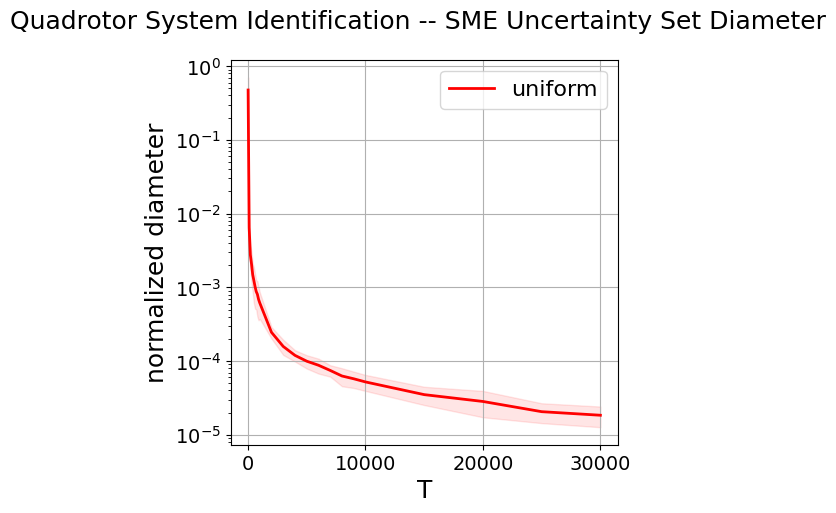

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

plt.rcParams['axes.grid'] = True

linewidth_ = 2.0
alpha_ = 0.1
log_scale = True
normalize = True
l_norm = np.inf # 2

def plot_sme_diam(mean_diam, std_diam, time_hor):

  c0 = 1
  if normalize:
    c0 = np.linalg.norm(ground_truth, l_norm)

  time_hor_ = np.array(time_hor)

  fig = plt.figure(figsize=(5, 5))
  plt.plot(time_hor, np.array(mean_diam) / c0, color='red', label=disturbance, linewidth=linewidth_)
  plt.fill_between(time_hor, (np.array(mean_diam) - np.array(std_diam)) / c0, (np.array(mean_diam) + np.array(std_diam)) / c0, color='red', alpha=alpha_)
  # plt.xticks([10, 10000, 20000, 30000])
  plt.xlabel('T')
  if normalize:
    plt.ylabel('normalized diameter')
  else:
    plt.ylabel('diameter')
  plt.legend()
  fig.suptitle('Quadrotor System Identification -- SME Uncertainty Set Diameter')
  if log_scale:
    plt.yscale('log')

  plt.show()

print('------------------------SME Uncertainty Set Diameter Plot---------------------')
plot_sme_diam(mean_diam_list, std_diam_list, time_hor)

# Plot SME Polyhedron

------------------------SME Uncertainty Set Plots----------------------


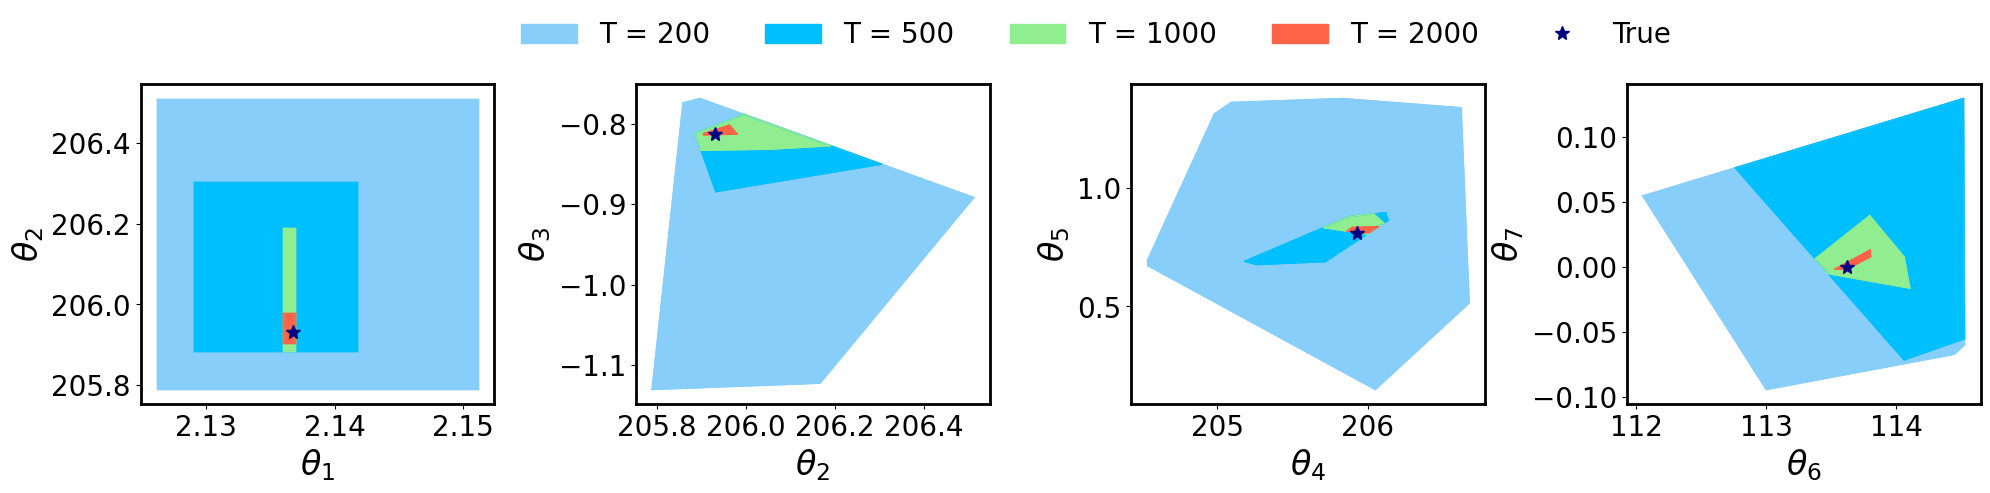

In [ ]:
from scipy.spatial import HalfspaceIntersection
from scipy.optimize import linprog
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['axes.grid'] = False
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2

linewidth_ = 1
alpha_ = 1

def plot_sm_(inter_points, time_hor, ground_truth, w_max):
    kxs = [0, 5, 7, 9]
    kys = [5, 4, 6, 8]
    ix = [0, 1, 2, 3]

    # colors = ['red', 'cyan', 'yellow', 'magenta', 'pink', 'red', 'blue', 'orange', 'green', 'cyan', 'yellow', 'magenta', 'pink', 'red']
    # colors = ['red', 'cyan', 'yellow', 'magenta', 'pink', 'orange', 'blue', 'whitesmoke', 'white']
    # colors = ['deepskyblue', 'teal', 'yellowgreen', 'pink', 'tomato']
    colors = ['lightskyblue', 'deepskyblue', 'lightgreen', 'tomato']
    lbls = ['T = ', 'T = ', 'T = ', 'T = ', 'T = ', 'T = ', 'T = ', 'T = ']

    fig, axs = plt.subplots(1, 4, figsize=(23, 4))
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.2)

    for i in range(len(kxs)):
        for t in range(len(inter_points)):
            n_points = np.zeros((inter_points[t].shape[0], 2))
            n_points[:, 0] = inter_points[t][:, kxs[i]]
            n_points[:, 1] = inter_points[t][:, kys[i]]

            hull = ConvexHull(n_points)
            # axs[ix[i], iy[i]].plot(n_points[:, 0], n_points[:, 1], 'o')

            for simplex in hull.simplices:
                axs[ix[i]].plot(n_points[simplex, 0], n_points[simplex, 1], color=colors[t], linewidth=linewidth_)
            axs[ix[i]].fill(n_points[hull.vertices, 0], n_points[hull.vertices, 1], alpha=alpha_, color=colors[t],
                                   label=lbls[t] + str(time_hor[t]))  # color=colors[t]

            if t == len(inter_points) - 1:
                axs[ix[i]].plot(ground_truth[kxs[i]], ground_truth[kys[i]], '*', markersize=10, markerfacecolor='navy',
                                       markeredgecolor='navy', label='True')

    axs[0].set_xlabel('$\\theta_{1}$')  # ('$\\frac{1}{m}$')
    axs[0].set_ylabel('$\\theta_{2}$') # ('$\\frac{1}{I_{xx}}$')

    axs[1].set_xlabel('$\\theta_{2}$')  # ('$\\frac{1}{I_{xx}}$')
    axs[1].set_ylabel('$\\theta_{3}$')  # ('$\\frac{I_{yy}-I_{zz}}{I_{xx}}$')

    axs[2].set_xlabel('$\\theta_{4}$') #  ('$\\frac{1}{I_{yy}}$')
    axs[2].set_ylabel('$\\theta_{5}$')  # ('$\\frac{I_{zz}-I_{xx}}{I_{yy}}$')

    axs[3].set_xlabel('$\\theta_{6}$')  # ('$\\frac{1}{I_{zz}}$') # ('$\\frac{1}{I_{zz}}$')
    axs[3].set_ylabel('$\\theta_{7}$')   # ('$\\frac{I_{xx}-I_{yy}}{I_{zz}}$')

    axs[0].legend(bbox_to_anchor=(2.7, 1.275), ncol=len(time_hor) + 1, loc='upper center', edgecolor='white')

    plt.show()

print('------------------------SME Uncertainty Set Plots----------------------')
point_list = [intersection_points[2][0], intersection_points[5][0], intersection_points[10][0], intersection_points[11][0]]
time_list = [time_hor[2], time_hor[5], time_hor[10], time_hor[11]]
plot_sm_(point_list, time_list, ground_truth, w_max)
# [10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 15000, 20000, 25000, 30000]
